In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *
from scipy.stats import chi2

In [2]:
class KldMcl(Mcl):
    def __init__(self, envmap, init_pose, max_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.11, "oo":0.2},
                 distance_dev_rate=0.14, direction_dev=0.05,
                 widths=np.array([0.2, 0.2, math.pi/18]).T, epsilon=0.1, delta=0.01):
        
        super().__init__(envmap, init_pose, 1, motion_noise_stds, distance_dev_rate, direction_dev)
        self.widths = widths                           # 各ビンのxyθの幅
        self.max_num = max_num                        # パーティクル数の上限(1000)
        self.epsilon = epsilon                        # ε
        self.delta = delta                            # δ
        self.binnum = 0                               # ビンの数k
        
    def motion_update(self, nu, omega, time):
        ws = [e.weight for e in self.particles]                           # 重みのリスト
        if sum(ws) < 1e-100:
            ws = [e + 1e-100 for e in ws]                                 # 重みの合計が0のときの処理
            
        new_particles = []                                                # 新しいパーティクルのリスト
        bins = set()                                                      # ビンのインデックスを登録しておくセット
        for i in range(self.max_num):
            chosen_p = random.choices(self.particles, weights=ws)         # 1つ選ぶ
            p = copy.deepcopy(chosen_p[0])                                # poseをコピー
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)  # 移動（パーティクルの姿勢を更新）
            bins.add(tuple(math.floor(e) for e in p.pose/self.widths))    # 新しく入るビンのインデックスをsetに登録
            new_particles.append(p)                                       # 新しいパーティクルのリストに追加
            
            self.binnum = len(bins) if len(bins) > 1 else 2               # ビンの数が1の場合2にしないと次の行が計算できない
            if len(new_particles) > math.ceil(chi2.ppf(1.0 - self.delta, self.binnum-1)/(2*self.epsilon)):
                break                                                     # 新しいパーティクルの数が式(7.21)を超えると終了
                                                                          # パーティクルの数とビンの数が増えていき、やがてビンの数は増えなくなる
        self.particles = new_particles                                    # パーティクルの更新
        for i in range(len(self.particles)):
            self.particles[i].weight = 1.0/len(self.particles)            # 重みの正規化
        
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev)
        self.set_ml()                                                     # 代表パーティクルを選ぶ（リサンプリング前に実行）
        # リサンプリングはmotion_updateで行う
        
    def draw(self, ax, elems):                                            # パーティクルとビンの数を表示
        super().draw(ax, elems)
        elems.append(ax.text(-4.5, -4.5, "particle:{}, bin:{}".format(len(self.particles), self.binnum), fontsize=10))
        

<IPython.core.display.Javascript object>


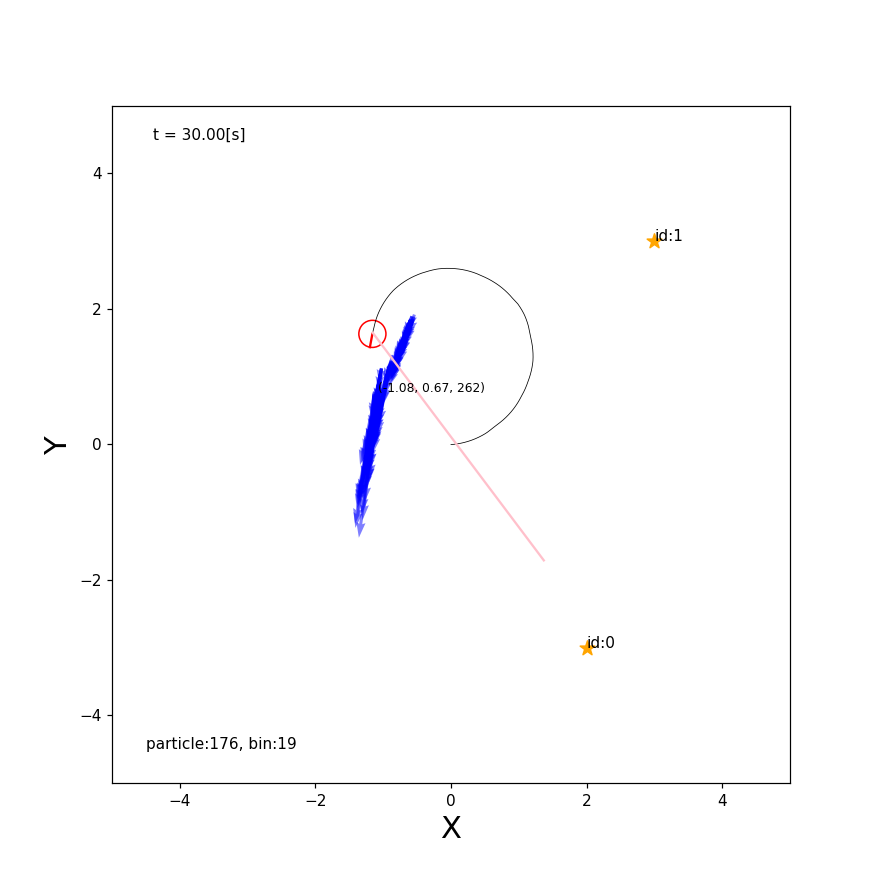

In [3]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    # 地図を作成してランドマークを追加
    m = Map()
    for ln in [(2, -3), (3, 3)]:
        m.append_landmark(LandMark(*ln))
    world.append(m)
    
    # ロボットを作る
    initial_pose = np.array([0, 0, 0]).T
    pf = KldMcl(m, initial_pose, 1000)                                        # パーティクルフィルタを作る 地図を持たせる
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)      # estimatorを渡す
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    # アニメーション実行
    world.draw()
    
trial()